In [1]:
library(edgeR)
library(ggplot2)
library(org.Hs.eg.db)

Loading required package: limma

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'c

In [2]:
## change working directory
Input_dir = '/mnt/d/Lab_wsl/PJW_Study/Data_anaylsis/DEG/3.FeatureCounts/'
setwd(Input_dir)

In [3]:
## Load the data
Data = read.table("./BRCA_ER.txt", header = T, skip = 1)
head(Data)

,Geneid,Chr,Start,End,Strand,Length,Cancer1,Cancer2,Cancer3,Control1,Control2,Control3
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000223972,1;1;1;1;1;1;1;1;1,11869;12010;12179;12613;12613;12975;13221;13221;13453,12227;12057;12227;12721;12697;13052;13374;14409;13670,+;+;+;+;+;+;+;+;+,1735,0,0,0,0,0,0
2,ENSG00000227232,1;1;1;1;1;1;1;1;1;1;1,14404;15005;15796;16607;16858;17233;17606;17915;18268;24738;29534,14501;15038;15947;16765;17055;17368;17742;18061;18366;24891;29570,-;-;-;-;-;-;-;-;-;-;-,1351,104,122,78,107,51,55
3,ENSG00000278267,1,17369,17436,-,68,20,12,13,18,9,10
4,ENSG00000243485,1;1;1;1;1;1,29554;30267;30366;30564;30976;30976,30039;30667;30503;30667;31097;31109,+;+;+;+;+;+,1021,0,0,0,0,0,0
5,ENSG00000237613,1;1;1;1;1,34554;35245;35277;35721;35721,35174;35481;35481;36073;36081,-;-;-;-;-,1219,0,0,0,0,0,0
6,ENSG00000268020,1,52473,53312,+,840,0,0,0,0,0,0


In [4]:
# make Countmatrix.
CountData = Data[, seq(from = 7, to = ncol(Data))]
head(CountData)

,Cancer1,Cancer2,Cancer3,Control1,Control2,Control3
,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0
2,104,122,78,107,51,55
3,20,12,13,18,9,10
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0


In [5]:
# Make group infomation
group = factor(c(rep("Cancer", 3), rep("Control", 3)))
group = relevel(group, "Control")
group

[1] Cancer  Cancer  Cancer  Control Control Control
Levels: Control Cancer

In [6]:
y = DGEList(counts = CountData, group = group)
head(y)

An object of class "DGEList"
$counts
  Cancer1 Cancer2 Cancer3 Control1 Control2 Control3
1       0       0       0        0        0        0
2     104     122      78      107       51       55
3      20      12      13       18        9       10
4       0       0       0        0        0        0
5       0       0       0        0        0        0
6       0       0       0        0        0        0

$samples
           group lib.size norm.factors
Cancer1   Cancer 53949167            1
Cancer2   Cancer 54073586            1
Cancer3   Cancer 52635435            1
Control1 Control 64999453            1
Control2 Control 53854877            1
Control3 Control 46502159            1

In [7]:
# Gene annotation
multiVals = function(x) paste(x, collapse = ";")
Symbol = mapIds(org.Hs.eg.db, keys = rownames(y), 
                keytype = "ENTREZID", column = "SYMBOL", multiVals = multiVals)
y$genes = data.frame(Symbol = Symbol, stringsAsFactors = FALSE)

'select()' returned 1:1 mapping between keys and columns



In [8]:
# Filter genes with very low counts across all libraries.
keep = filterByExpr(y)
y = y[keep, , keep.lib.sizes = FALSE]

In [9]:
# Normalize the library sizes by finding a set of scaling factors for library size.
y = calcNormFactors(y)
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
Cancer1,Cancer,53912822,1.1130842
Cancer2,Cancer,54036932,1.1112474
Cancer3,Cancer,52598357,1.0885168
Control1,Control,64973644,0.9002252
Control2,Control,53835756,0.9048977
Control3,Control,46484873,0.9117493


In [10]:
# make model for Differentially gene expression by group
Design = model.matrix(~ group)
Design

,(Intercept),groupCancer
1,1,1
2,1,1
3,1,1
4,1,0
5,1,0
6,1,0


In [11]:
# Check dispersion. (variation check)
y = estimateDisp(y, Design)
y

,Cancer1,Cancer2,Cancer3,Control1,Control2,Control3
2,104,122,78,107,51,55
3,20,12,13,18,9,10
19,97,82,122,110,96,82
21,51,38,30,7,3,2
35,21,22,27,22,10,18
36,6294,5650,7601,8731,5558,5737
37,2145,1658,3569,1745,856,1214
39,237,132,193,225,73,106
41,24851,22266,27794,28978,18304,18537
42,127,107,123,203,80,92


In [12]:
# Perform quasi-likehoold F-test.
fit = glmQLFit(y, Design)
qlt = glmQLFTest(fit, coef = 2)
topTags(qlt)

,Symbol,logFC,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48811,NA,10.002453,6.621865,12403.444,4.851566e-25,9.060784e-21
28220,NA,3.355587,7.649512,10874.484,1.424209e-24,1.184355e-20
21228,NA,3.622280,9.219858,10241.759,2.326261e-24,1.184355e-20
3971,NA,6.251815,6.452778,10133.991,2.536635e-24,1.184355e-20
52914,NA,3.154560,8.271813,8932.228,7.126634e-24,2.610991e-20
12346,NA,3.157542,7.432057,8628.958,9.454367e-24,2.610991e-20
21862,NA,3.555547,6.846893,8592.641,9.786324e-24,2.610991e-20
54521,WDR44,3.106577,7.684615,8153.931,1.502561e-23,3.507728e-20
39883,NA,3.283070,6.701488,7906.512,1.933357e-23,3.728342e-20


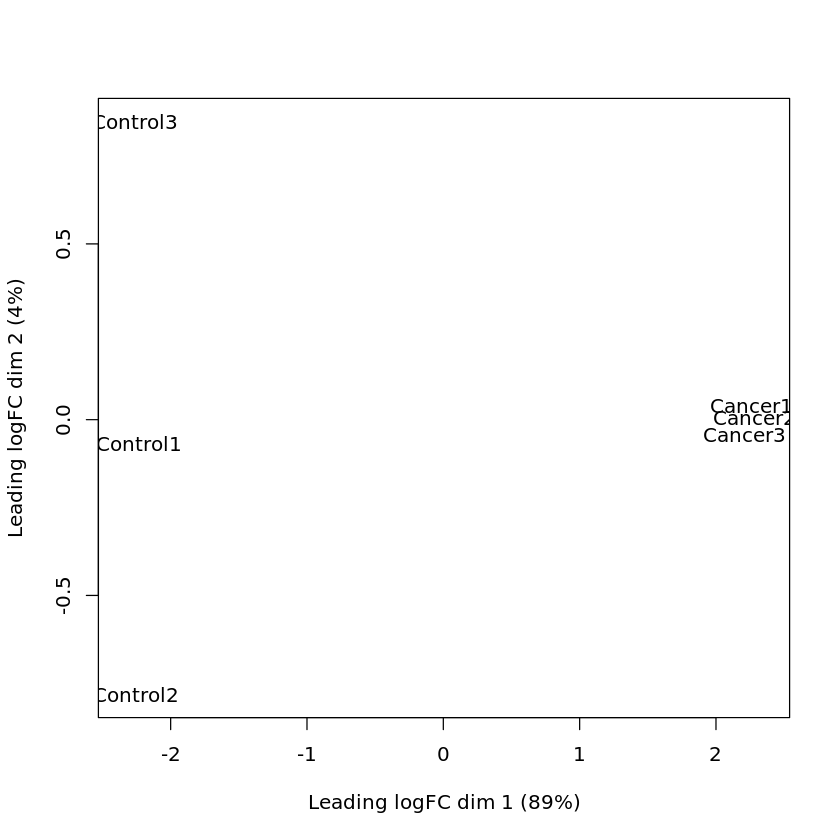

In [13]:
# Clustering
logcpm = cpm(y, log = TRUE)
plotMDS(logcpm)

In [14]:
# Gene ontology and pathway analysis
go = goana(qlt, species = "Hs")
topGO(go, sort = "up")

,Term,Ont,N,Up,Down,P.Up,P.Down
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0061351,neural precursor cell proliferation,BP,42,29,9,0.001117980,0.9954468
GO:1903047,mitotic cell cycle process,BP,190,105,62,0.001584623,0.9738216
GO:0009636,response to toxic substance,BP,75,46,19,0.002369279,0.9958661
GO:0001824,blastocyst development,BP,16,13,2,0.003052973,0.9959522
GO:0042743,hydrogen peroxide metabolic process,BP,21,16,2,0.003236271,0.9995667
GO:0062197,cellular response to chemical stress,BP,92,54,26,0.004099931,0.9889647
GO:0034451,centriolar satellite,CC,23,17,3,0.004118247,0.9986669
GO:0016684,"oxidoreductase activity, acting on peroxide as acceptor",MF,23,17,5,0.004118247,0.9766307
GO:0004601,peroxidase activity,MF,23,17,5,0.004118247,0.9766307


In [15]:
keg = kegga(qlt, species = "Hs")
topKEGG(keg, sort = "up")

,Pathway,N,Up,Down,P.Up,P.Down
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
path:hsa04540,Gap junction,32,23,6,0.001027378,0.9969845
path:hsa04392,Hippo signaling pathway - multiple species,8,8,0,0.001244634,1.0000000
path:hsa00480,Glutathione metabolism,16,13,3,0.002287871,0.9808892
path:hsa05030,Cocaine addiction,16,12,3,0.010523961,0.9808892
path:hsa00513,Various types of N-glycan biosynthesis,8,7,1,0.014267982,0.9827058
path:hsa04730,Long-term depression,24,16,6,0.018125971,0.9581811
path:hsa04010,MAPK signaling pathway,104,55,34,0.031344198,0.9443637
path:hsa04150,mTOR signaling pathway,33,20,10,0.034458667,0.9034438
path:hsa04024,cAMP signaling pathway,82,44,23,0.038397334,0.9901591


In [17]:
# Draw volcano plot
DEG_result = qlt$table
DEG_result$FDR = p.adjust(DEG_result$PValue, "fdr")

# add a column of NAs
DEG_result$diffexpressed = "No significant"
DEG_result$diffexpressed[DEG_result$logFC > 0 & DEG_result$FDR < 0.01] = "Upregulated"
DEG_result$diffexpressed[DEG_result$logFC < 0 & DEG_result$FDR < 0.01] = "Downregulated"

In [18]:
logFC = DEG_result$logFC
padj = DEG_result$FDR

In [19]:
p = ggplot(data = DEG_result, aes(x = logFC, y = -log10(padj), col = diffexpressed)) + geom_point() + xlim(c(-15, 15)) + theme_minimal()

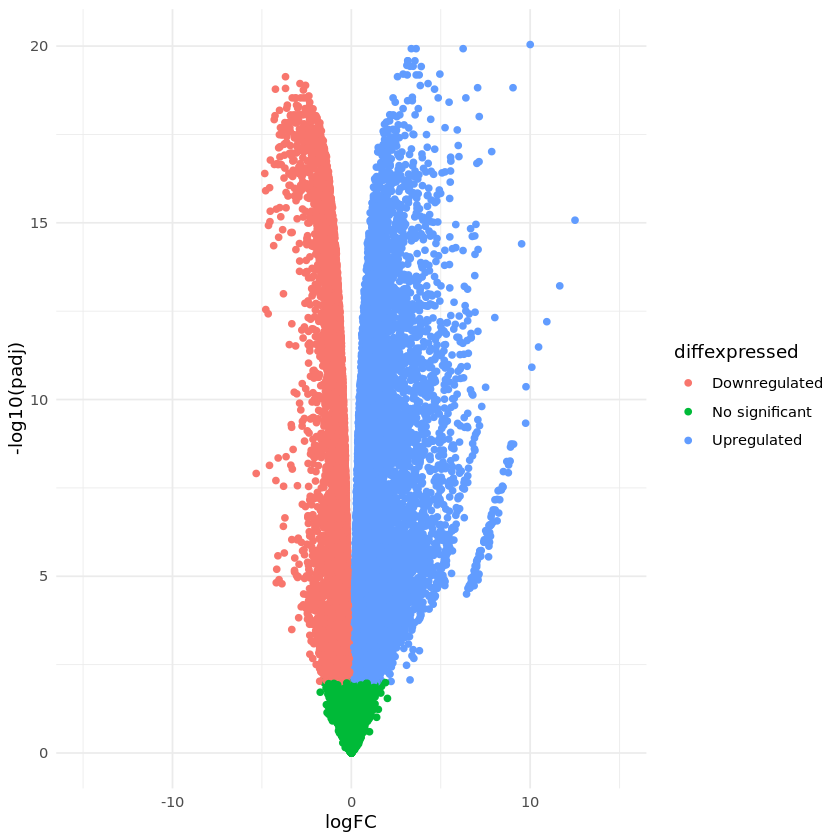

In [20]:
p